In [1]:
# Mountain Car- v0 solution using action-value neural network function approximator

In [30]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
# from torch.autograd import Variable

# One hidden layer function approximator
class action_value_function(nn.Module):

    def __init__(self):

        super(action_value_function, self).__init__()
        self.block = nn.Sequential(
            torch.nn.Linear(2, 100, bias = False),
#             torch.nn.ReLU(),
#             torch.nn.Linear(20, 4),
#             torch.nn.ReLU(),
            torch.nn.Linear(100, 3, bias = False),
#             torch.nn.Softmax(),
        )

    def forward(self, input):
        return self.block(input)
    
# I tried different weight initializations but found they did not perform well.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)


In [31]:
# Instaciate action_value_function class
q_hat = action_value_function()
# q_hat.apply(weights_init)

In [32]:
import gym
import numpy as np

done = False
LEARNING_RATE = 0.1
DISCOUNT = 0.99
EPISODES = 25000
SHOW_EVERY = 300
BATCH_SIZE = 4

env = gym.make("MountainCar-v0")
env.reset()

DISCRETE_OS_SIZE = [20, 20] #* len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE


In [33]:
# Test number of actions and other parameters
print('observation_space:',env.observation_space.low,'to',env.observation_space.high,'| Number of action values:',env.action_space.n)

observation_space: [-1.2  -0.07] to [0.6  0.07] | Number of action values: 3


In [34]:
# Function for discretization of observation state space
def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))  # we use this tuple to look up the 3 Q values for the available actions in the q-table

# Sampled version of q value table
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

In [35]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(q_hat.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


In [39]:
avg_loss = 0
epsilon = 0.3
curr_high_pos = 0
curr_low_pos = 0
successes = 0
tot_reward = np.array([])

#################### | RENDERING | ####################
Episode: 0 | Average Loss: 0.6607691368460655 | Epsilon: 0.2988012


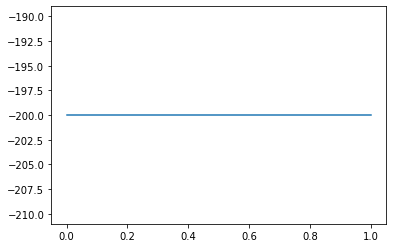

KeyboardInterrupt: 

In [42]:
# Train agent
import random

for episode in range(EPISODES):
   
    state = torch.from_numpy(env.reset()).float()
    done = False
    
    if episode%SHOW_EVERY == 0:
        print('#'*50,'| RENDERING |','#'*49)
        RENDER = True
    else:
        RENDER = False

    running_loss = 0

    while not done:
        if RENDER:
            env.render()
        
        q = q_hat(state)
        
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q).item()
        
        next_state, reward, done, _ = env.step(action)
        next_state = torch.from_numpy(next_state).float()
        
        q_target = q.clone()
        q_target = q_target.data
        
        q_target[action] = reward + DISCOUNT * max(q_hat(next_state).detach())
        # Calculate loss
        loss = criterion(q, q_target)
        optimizer.zero_grad()
    
        loss.backward()
    
        optimizer.step()
        # zero the parameter gradients

        if next_state[0] >= 0.5:
            epsilon *= .99
            scheduler.step()
            break 
        

        else:
            state = next_state
    
        running_loss += loss.item()
            
    avg_loss += running_loss
    env.close()
    if episode%100 == 0:
        print('Episode:',episode,'| Average Loss:',avg_loss/100, '| Epsilon:',epsilon)
        avg_loss = 0


# env.close()

In [29]:
# Test your policy
env.close()
state = torch.from_numpy(env.reset()).float()
done = False
while not done:
    env.render()
    q = q_hat(state)
    action = torch.argmax(q).item()

    next_state, reward, done, _ = env.step(action)
    next_state = torch.from_numpy(next_state).float()
    state = next_state
    
env.close()

In [ ]:
type(q_target)

In [ ]:
print('this {}'.format(epsilon))


In [ ]:
# import ipympl

import matplotlib.pyplot as plt
import gym
import numpy as np
# from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
# from tensorboardX import SummaryWriter
from datetime import datetime
import glob, os

In [ ]:
env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)
# PATH = glob.glob(os.path.expanduser('~/tboardlogs/'))[0]
# writer = SummaryWriter('~/tboardlogs/{}'.format(datetime.now().strftime('%b%d_%H-%M-%S')))

In [ ]:
max_position = -.4
positions = np.ndarray([0,2])
rewards = []
successful = []
for episode in range(1000):
    running_reward = 0
    env.reset()
    done = False
    for i in range(200):
        state, reward, done, _ = env.step(np.random.randint(0,3))
        # Give a reward for reaching a new maximum position
        if state[0] > max_position:
            max_position = state[0]
            positions = np.append(positions, [[episode, max_position]], axis=0)
            running_reward += 10
        else:
            running_reward += reward
        if done: 
            if state[0] >= 0.5:
                successful.append(episode)
            rewards.append(running_reward)
            break

print('Furthest Position: {}'.format(max_position))
plt.figure(1, figsize=[10,5])
plt.subplot(211)
plt.plot(positions[:,0], positions[:,1])
plt.xlabel('Episode')
plt.ylabel('Furthest Position')
plt.subplot(212)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('successful episodes: {}'.format(np.count_nonzero(successful)))

In [ ]:
# # I tried different weight initializations but found they did not perform well.
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Linear') != -1:
#         nn.init.normal_(m.weight, 0, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 200
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)

In [ ]:
# Parameters
steps = 2000
state = env.reset()
epsilon = 0.3
gamma = 0.99
loss_history = []
reward_history = []
episodes = 3000
max_position = -0.4
learning_rate = 0.001
successes = 0
position = []
done = False

# Initialize Policy
policy = Policy()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

for episode in range(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()
#     print(episode)

    for s in range(steps):
#     while not(done):
#         Uncomment to render environment
        if episode % 300 == 0 and episode > 0:
           env.render()
        
        # Get first action value function
        Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # Step forward and receive next state and reward
        state_1, reward, done, _ = env.step(action)
        
        # Find max Q for t+1 state
        Q1 = policy(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
        maxQ1, _ = torch.max(Q1, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target.data)
        Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
#         print(loss)
        # Update policy
        policy.zero_grad()
        loss.backward()
        optimizer.step()

        # Record history
        episode_loss += loss.item()
        episode_reward += reward
        # Keep track of max position
        if state_1[0] > max_position:
            max_position = state_1[0]
#             writer.add_scalar('data/max_position', max_position, episode)
        
        if done:
            if state_1[0] >= 0.5:
                # On successful epsisodes, adjust the following parameters
                print('I nailed it!')
                # Adjust epsilon
                epsilon *= .99
#                 writer.add_scalar('data/epsilon', epsilon, episode)

                # Adjust learning rate
                scheduler.step()
#                 writer.add_scalar('data/learning_rate', optimizer.param_groups[0]['lr'], episode)

                # Record successful episode
                successes += 1
#                 writer.add_scalar('data/cumulative_success', successes, episode)
#                 writer.add_scalar('data/success', 1, episode)
            
            elif state_1[0] < 0.5:
#                 writer.add_scalar('data/success', 0, episode)
                pass
            
            # Record history
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)
#             writer.add_scalar('data/episode_loss', episode_loss, episode)
#             writer.add_scalar('data/episode_reward', episode_reward, episode)
            weights = np.sum(np.abs(policy.l2.weight.data.numpy()))+np.sum(np.abs(policy.l1.weight.data.numpy()))
#             writer.add_scalar('data/weights', weights, episode)
#             writer.add_scalar('data/position', state_1[0], episode)
            position.append(state_1[0])

            break
        else:
            state = state_1
            
# writer.close()
print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

In [ ]:
episode

In [ ]:
import torch

In [ ]:
k = torch.ones(3,1)

In [ ]:
k[2] = 15
print(k)

In [ ]:
torch.argmax(k).item()